# Quantum Entanglement

## Teleportation

*Quantum teleportation*, or just teleportation for short, is a protocol where a sender (Alice) transmits a qubit to a receiver (Bob) by making use of a shared entangled quantum state (one *e-bit*, to be specific) along with two bits of classical communication. We assume that Alice and Bob share an *e-bit*: Alice holds a qubit $A$, Bob holds a qubit $B$, and together the pair $(A,B)$ is in the state $| \phi^{+} \rangle$. Alice then comes into possession of a third qubit $Q$ that she wishes to transmit to Bob. The state of the qubit $Q$ is considered to be unknown to Alice and Bob, and no assumptions are made about it. 

Here is a quantum circuit diagram that describes the teleportation protocol:
![teleportation protocol](teleportation.png)

In words, the teleportation protocol is as follows:

1. Alice performs a controlled-NOT operation on the pair $(A,Q)$, with $Q$ being the control and $A$ being the target, and then performs a Hadamard operation on $Q$.

2. Alice then measures both $A$ and $Q$, with respect to a standard basis measurement in both cases, and transmits the classical outcomes to Bob. Let us refer to the outcome of the measurement of $A$ as $a$ and the outcome of the measurement of $Q$ as $q$.

3. Bob receives $a$ and $q$ from Alice, and depending on the values of these bits he performs these operations:

- If $a=1$, then Bob performs a bit flip (or $X$ gate) on his qubit $B$.
- If $q=1$, then Bob performs a phase flip (or $Z$ gate) on his qubit $B$.

That is, conditioned on $aq$ being $00$, $01$, $10$, or $11$, Bob performs one of the operations $\mathbb{1}$, $Z$, $X$ or $ZX$ on the qubit $B$.

Here is a quantum circuit implementation of the teleportation protocol.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

Q = QuantumRegister(1, "Q")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
q = ClassicalRegister(1, "q")

protocol = QuantumCircuit(Q,A,B,a,q)

# Preparation of ebit for teleportation
protocol.h(A)
protocol.cx(A, B)
protocol.barrier()

# Alice's operations
protocol.cx(Q, A)
protocol.h(Q)
protocol.barrier()

# Alice's measurements sends classical bits to Bob
protocol.measure(A, a)
protocol.measure(Q, q)
protocol.barrier()

# Bob uses a and q to apply gates

with protocol.if_test((a,1)):
    protocol.x(B)
with protocol.if_test((q,1)):
    protocol.z(B)

#result = ClassicalRegister(1, "Result")
#protocol.add_register(result)
#protocol.measure(B, result)

protocol.draw()

░      ┌───┐ ░    ┌─┐ ░                         
Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────
   ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                         
A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────
   └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐┌──────────┐
B: ─────┤ X ├─░────────────░──╫──╫──░─┤0         ├┤0         ├
        └───┘ ░            ░  ║  ║  ░ │  If_else ││          │
a: ═══════════════════════════╩══╬════╡0         ╞╡          ╞
                                 ║    └──────────┘│          │
q: ══════════════════════════════╩════════════════╡0         ╞
                                                  └──────────┘

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs.

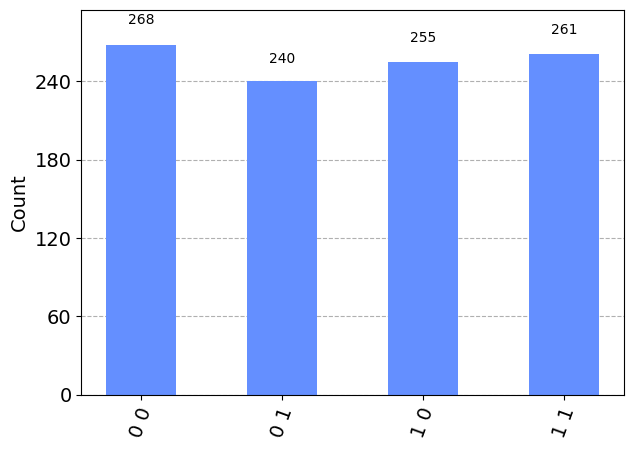

In [2]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

counts = AerSimulator().run(protocol).result().get_counts()
plot_histogram(counts)

We can also filter the counts to focus just on the test result qubit if we wish, like this:

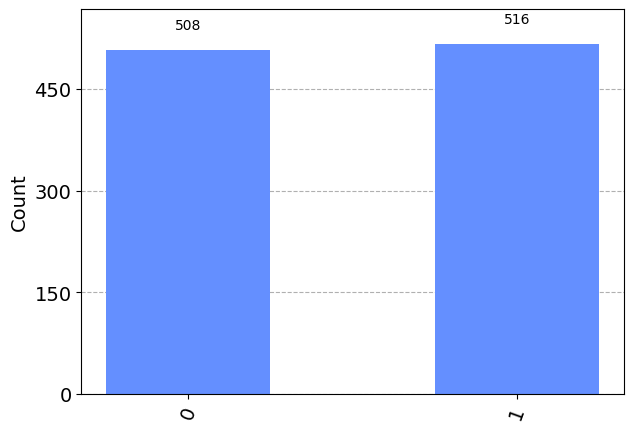

In [3]:
filtered_counts = {"0": 0, "1": 0}

for result, frequency in counts.items():
    filtered_counts[result[0]] += frequency

plot_histogram(filtered_counts)

Let us redefine the above quantum circuit again.

In [4]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw()

░      ┌───┐ ░    ┌─┐ ░                         
Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────
   ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                         
A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────
   └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐┌──────────┐
B: ─────┤ X ├─░────────────░──╫──╫──░─┤0         ├┤0         ├
        └───┘ ░            ░  ║  ║  ░ │  If_else ││          │
a: ═══════════════════════════╩══╬════╡0         ╞╡          ╞
                                 ║    └──────────┘│          │
b: ══════════════════════════════╩════════════════╡0         ╞
                                                  └──────────┘

To test that the protocol works correctly, let's check that it correctly teleports half of an entangled pair. We can do this by creating a new circuit including a qubit $R$, composing it with our protocol, and then adding gates and measurements to perform the test.

In [5]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol, along with a new "auxiliary" qubit R.
aux = QuantumRegister(1, "R")
test = QuantumCircuit(aux, qubit, ebit0, ebit1, a, b)

# Entangle Q with R
test.h(aux)
test.cx(aux, qubit)
test.barrier()

# Append the protocol the circuit. The 'qubits' argument tells Qiskit that
# the protocol should operate on the qubits numbered 1, 2, and 3 (skipping
# qubit 0, which is R).
test = test.compose(protocol, qubits=[1, 2, 3])
test.barrier()

# After the protocol runs, check that (B,R) is in a phi+ state. We can add
# a new classical bit to the circuit to do this.
test.cx(aux, ebit1)
test.h(aux)
result = ClassicalRegister(1, "Test result")
test.add_register(result)
test.measure(aux, result)

display(test.draw())

┌───┐      ░                                                »
          R: ┤ H ├──■───░────────────────────────────────────────────────»
             └───┘┌─┴─┐ ░            ░      ┌───┐ ░    ┌─┐ ░             »
          Q: ─────┤ X ├─░────────────░───■──┤ H ├─░────┤M├─░─────────────»
                  └───┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░             »
          A: ───────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────»
                        ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐»
          B: ───────────░──────┤ X ├─░────────────░──╫──╫──░─┤0         ├»
                        ░      └───┘ ░            ░  ║  ║  ░ │  If_else │»
          a: ════════════════════════════════════════╩══╬════╡0         ╞»
                                                        ║    └──────────┘»
          b: ═══════════════════════════════════════════╩════════════════»
                                                                         »
Test result: ════════════════════════════════════════════════════════════»
                                                                         »
«                          ░      ┌───┐┌─┐
«          R: ─────────────░───■──┤ H ├┤M├
«                          ░   │  └───┘└╥┘
«          Q: ─────────────░───┼────────╫─
«                          ░   │        ║ 
«          A: ─────────────░───┼────────╫─
«             ┌──────────┐ ░ ┌─┴─┐      ║ 
«          B: ┤0         ├─░─┤ X ├──────╫─
«             │          │ ░ └───┘      ║ 
«          a: ╡          ╞══════════════╬═
«             │          │              ║ 
«          b: ╡0         ╞══════════════╬═
«             └──────────┘              ║ 
«Test result: ══════════════════════════╩═
«

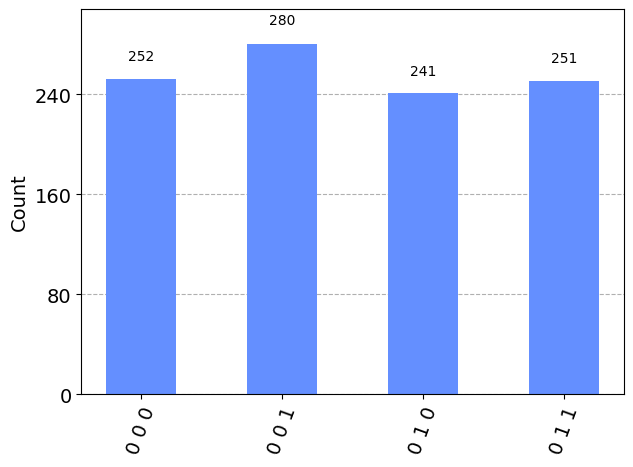

In [6]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)

### Superdense Coding

Superdense coding is a protocol that, in some sense, achieves a complementary aim to teleportation. Rather than allowing for the transmission of one qubit using two classical bits of communication (at the cost of one e-bit of entanglement), it allows for the transmission of two classical bits using one qubit of quantum communication (again, at the cost of one e-bit of entanglement).

In greater detail, we have a sender (Alice) and a receiver (Bob) that share one e-bit of entanglement. According to the conventions in place for the lesson, this means that Alice holds a qubit $A$, Bob holds a qubit $B$, and together the pair $(A,B)$ is in the state $|\phi^+ \rangle$. Alice wishes to transmit two classical bits to Bob, to be denoted by $a$ and $b$, and she will accomplish this by sending him one qubit.

The following quantum circuit diagram describes the superdense coding protocol:

![Superdense coding](superdense-coding.png)

In words, here is what Alice does:

1. Alice first checks to see if $b=1$. If $b=1$, she performs a $Z$ gate on her qubit $A$ (and if $b=0$ she does not).

2. Alice then checks to see if $a=1$. If $a=1$, she performs an $X$ gate on her qubit $A$ (and if $a=0$ she does not).

Alice then sends her qubit $A$ to Bob.

What Bob does when he receives the qubit $A$ is to first perform a controlled-NOT gate, with $A$ being the control and $B$ being the target, and then he applies a Hadamard gate to $A$. He then measures $B$ to obtain $a$ and $A$ to obtain $b$, with standard basis measurements in both cases.

Here is a simple implementation of superdense coding where we specify the circuit itself depending on the bits to be transmitted.

In [7]:
a = "0"
b=  "0"

In [8]:
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")

protocol = QuantumCircuit(A, B)

# prepare the e-bit

protocol.h(A)
protocol.cx(A,B)
protocol.barrier()

# Alice's operations
if b=="1":
    protocol.z(A)
if a=="1":
    protocol.x(A)

protocol.barrier()

# Bob's actions
protocol.cx(A,B)
protocol.h(A)
protocol.measure_all()

protocol.draw()

┌───┐      ░  ░      ┌───┐ ░ ┌─┐   
     A: ┤ H ├──■───░──░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░  ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
     B: ─────┤ X ├─░──░─┤ X ├──────░──╫─┤M├
             └───┘ ░  ░ └───┘      ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

Measured 00 with frequency 1024


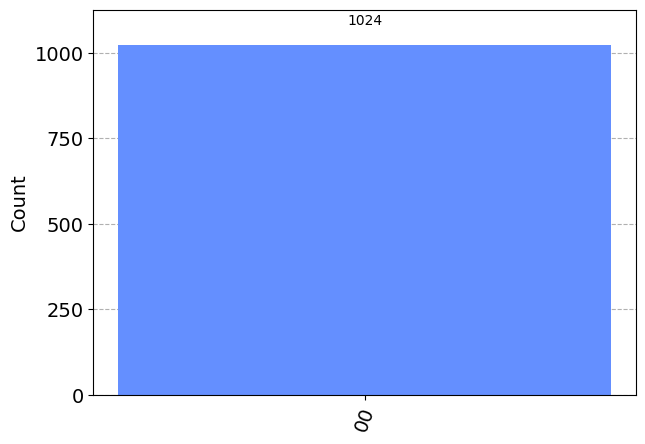

In [9]:
counts = AerSimulator().run(protocol).result().get_counts()
for outcome, frequency in counts.items():
    print(f"Measured {outcome} with frequency {frequency}")
plot_histogram(counts)

Just for fun, we can use an additional qubit as a random bit generator to randomly choose $a$ and $b$, then run the superdense coding protocol to see that these bits are transmitted correctly.

In [10]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_a = ClassicalRegister(1, "Alice a")
Alice_b = ClassicalRegister(1, "Alice b")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_b, Alice_a)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits a and b.
test.h(rbg)
test.measure(rbg, Alice_a)
test.h(rbg)
test.measure(rbg, Alice_b)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_b, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_a, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_a = ClassicalRegister(1, "Bob a")
Bob_b = ClassicalRegister(1, "Bob b")
test.add_register(Bob_b)
test.add_register(Bob_a)
test.measure(ebit1, Bob_a)
test.measure(ebit0, Bob_b)

test.draw()

░ ┌───┐┌─┐┌───┐┌─┐ ░              ░            ░       
randomizer: ───────────░─┤ H ├┤M├┤ H ├┤M├─░──────────────░────────────░───────
            ┌───┐      ░ └───┘└╥┘└───┘└╥┘ ░ ┌────┐┌────┐ ░      ┌───┐ ░    ┌─┐
         A: ┤ H ├──■───░───────╫───────╫──░─┤0   ├┤0   ├─░───■──┤ H ├─░────┤M├
            └───┘┌─┴─┐ ░       ║       ║  ░ │    ││    │ ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘
         B: ─────┤ X ├─░───────╫───────╫──░─┤  Z ├┤    ├─░─┤ X ├──────░─┤M├─╫─
                 └───┘ ░       ║       ║  ░ │    ││  X │ ░ └───┘      ░ └╥┘ ║ 
   Alice b: ═══════════════════╬═══════╩════╡0   ╞╡    ╞═════════════════╬══╬═
                               ║            └────┘│    │                 ║  ║ 
   Alice a: ═══════════════════╩══════════════════╡0   ╞═════════════════╬══╬═
                                                  └────┘                 ║  ║ 
     Bob b: ═════════════════════════════════════════════════════════════╬══╩═
                                                                         ║    
     Bob a: ═════════════════════════════════════════════════════════════╩════

Running the Aer simulator shows the results: Alice and Bob's classical bits always agree.

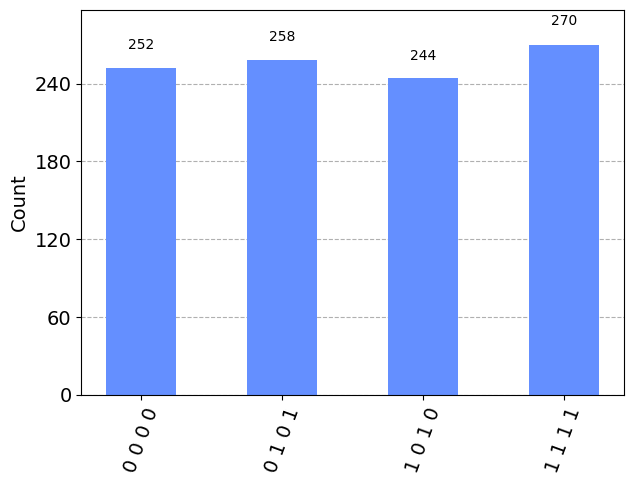

In [11]:
counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)

### The CHSH game

The CHSH game is a mathematical abstraction in the sense of game theory. Mathematical abstractions of games are studied in economics and computer science, for instance, and have great utility.

We can implement the CHSH game together with the quantum strategy defined above in Qiskit as follows.

First, here's the definition of the game itself, which allows an arbitrary strategy to be plugged in as an argument.

In [12]:
from numpy.random import randint

def chsh_game(strategy):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    x, y = randint(0, 2), randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

In [13]:
from numpy import pi

def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

In [14]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw())

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw())

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw())

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw())

(x,y) = (0,0)


┌───┐      ░  ┌───────┐  ┌─┐   
q_0: ┤ H ├──■───░──┤ Ry(0) ├──┤M├───
     └───┘┌─┴─┐ ░ ┌┴───────┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─░─┤ Ry(-π/4) ├─╫─┤M├
          └───┘ ░ └──────────┘ ║ └╥┘
c: 2/══════════════════════════╩══╩═
                               0  1

(x,y) = (0,1)


┌───┐      ░  ┌───────┐ ┌─┐   
q_0: ┤ H ├──■───░──┤ Ry(0) ├─┤M├───
     └───┘┌─┴─┐ ░ ┌┴───────┴┐└╥┘┌─┐
q_1: ─────┤ X ├─░─┤ Ry(π/4) ├─╫─┤M├
          └───┘ ░ └─────────┘ ║ └╥┘
c: 2/═════════════════════════╩══╩═
                              0  1

(x,y) = (1,0)


┌───┐      ░ ┌──────────┐┌─┐   
q_0: ┤ H ├──■───░─┤ Ry(-π/2) ├┤M├───
     └───┘┌─┴─┐ ░ ├──────────┤└╥┘┌─┐
q_1: ─────┤ X ├─░─┤ Ry(-π/4) ├─╫─┤M├
          └───┘ ░ └──────────┘ ║ └╥┘
c: 2/══════════════════════════╩══╩═
                               0  1

(x,y) = (1,1)


┌───┐      ░ ┌──────────┐┌─┐   
q_0: ┤ H ├──■───░─┤ Ry(-π/2) ├┤M├───
     └───┘┌─┴─┐ ░ ├─────────┬┘└╥┘┌─┐
q_1: ─────┤ X ├─░─┤ Ry(π/4) ├──╫─┤M├
          └───┘ ░ └─────────┘  ║ └╥┘
c: 2/══════════════════════════╩══╩═
                               0  1

In [15]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()


def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    # `memory=True` enables the `.get_memory()` method
    job = simulator.run(chsh_circuit(x, y), shots=1, memory=True)
    result = job.result().get_memory()[0]
    a, b = result[0], result[1]
    return a, b

In [16]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.849


We can also define a classical strategy and see how well it works. Feel free to change the code to try out different strategies!

In [17]:
def classical_strategy(x, y):
    """The best classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

In [18]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.756


In [19]:
# Half Adder

test = QuantumCircuit(4,2)

# we encode the input 10
test.x(0)

# It scarries out the adder circuit
test.cx(0,2)
test.cx(1,2)
test.ccx(0,1,3)

test.measure(2,0)
test.measure(3,1)
test.draw()

┌───┐                     
q_0: ┤ X ├──■─────────■────────
     └───┘  │         │        
q_1: ───────┼────■────■────────
          ┌─┴─┐┌─┴─┐  │  ┌─┐   
q_2: ─────┤ X ├┤ X ├──┼──┤M├───
          └───┘└───┘┌─┴─┐└╥┘┌─┐
q_3: ───────────────┤ X ├─╫─┤M├
                    └───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

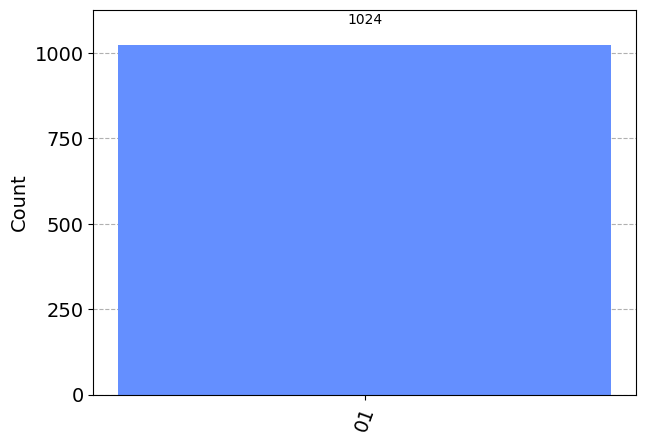

In [20]:
counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)